In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.fingernail import fingernail

%matplotlib inline 

In [2]:
FINGERNAIL_DIR = os.path.join(ROOT_DIR, "datasets/fingernail")
config = fingernail.FingernailConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
dataset = fingernail.FingernailDataset()
dataset.load_fingernail(FINGERNAIL_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 79
Class Count: 2
  0. BG                                                
  1. fingernail                                        


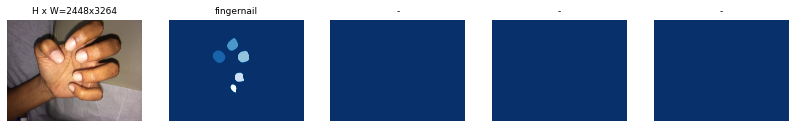

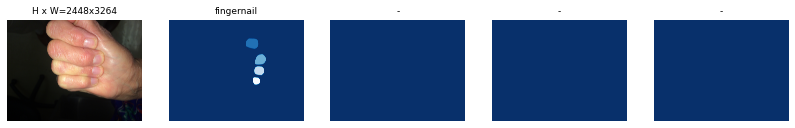

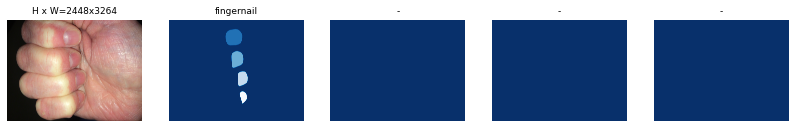

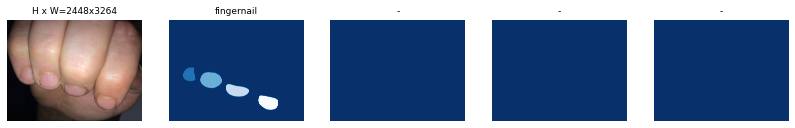

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  18 /Users/parker/Desktop/Mask_RCNN/datasets/fingernail/train/AAEGMH4.png
image                    shape: (2448, 3264, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (2448, 3264, 6)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (6,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (6, 4)                min:  268.00000  max: 2267.00000  int32


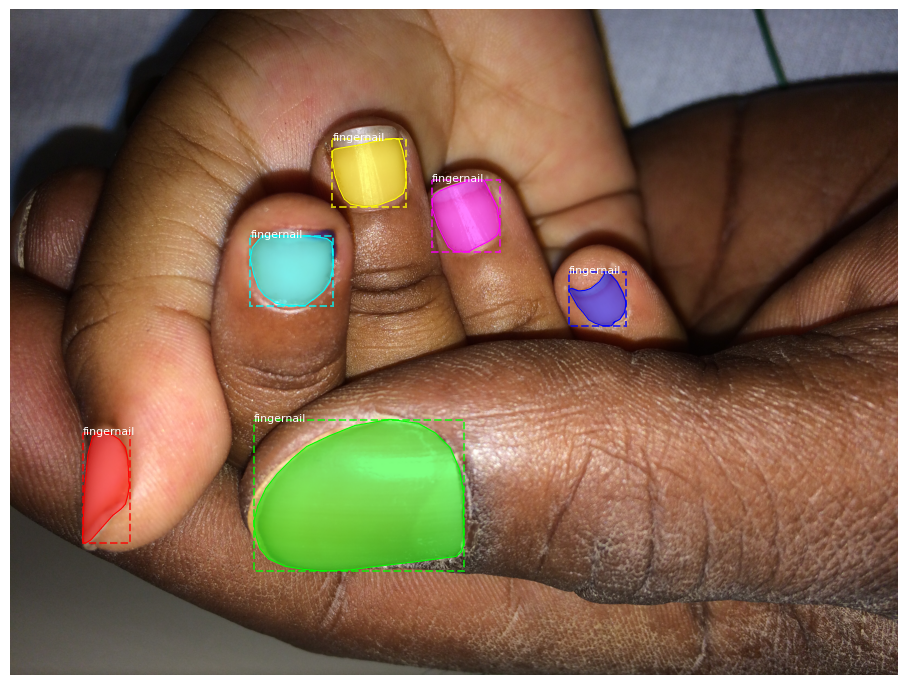

array([[[ 81,  76,  80],
        [ 84,  79,  83],
        [ 83,  81,  84],
        ...,
        [ 95, 102, 120],
        [100, 107, 125],
        [ 98, 105, 123]],

       [[ 78,  73,  77],
        [ 82,  77,  81],
        [ 82,  80,  83],
        ...,
        [ 99, 106, 124],
        [100, 107, 125],
        [ 99, 106, 124]],

       [[ 77,  75,  78],
        [ 79,  77,  80],
        [ 81,  79,  82],
        ...,
        [ 98, 105, 123],
        [ 97, 104, 122],
        [ 99, 106, 124]],

       ...,

       [[ 87,  80,  70],
        [ 86,  79,  69],
        [ 84,  77,  67],
        ...,
        [ 80,  65,  62],
        [ 78,  62,  62],
        [ 75,  59,  59]],

       [[ 91,  82,  73],
        [ 90,  81,  72],
        [ 88,  79,  70],
        ...,
        [ 70,  55,  52],
        [ 68,  52,  52],
        [ 59,  43,  43]],

       [[ 88,  79,  70],
        [ 88,  79,  70],
        [ 87,  78,  69],
        ...,
        [ 72,  57,  54],
        [ 76,  60,  60],
        [ 70,  54,  54]]

In [5]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id:  52 /Users/parker/Desktop/Mask_RCNN/datasets/fingernail/train/AAPLJM20.png
Original shape:  (2448, 3264, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (4,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (4, 4)                min:  249.00000  max:  828.00000  int32


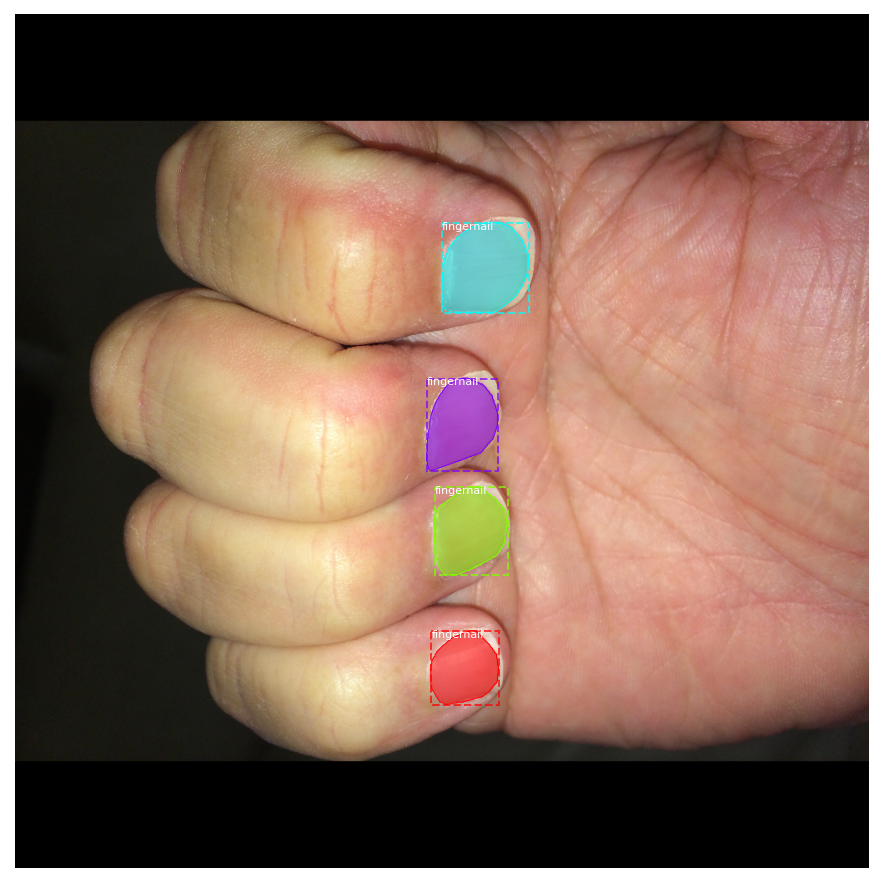

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [6]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 4032.00000  float64
class_ids                shape: (4,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (4, 4)                min:  309.00000  max:  807.00000  int32
mask                     shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  bool


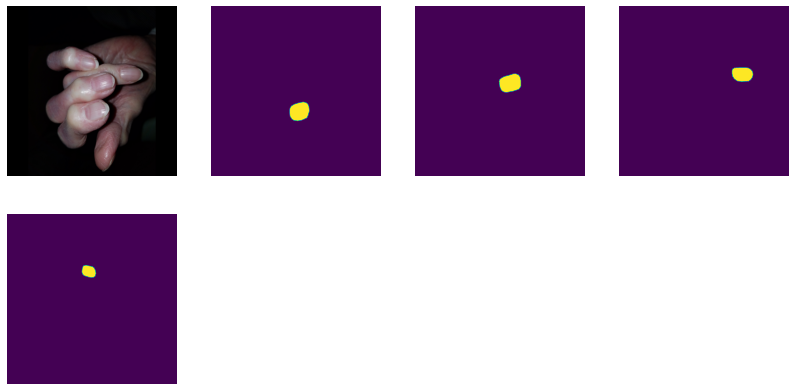

In [7]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

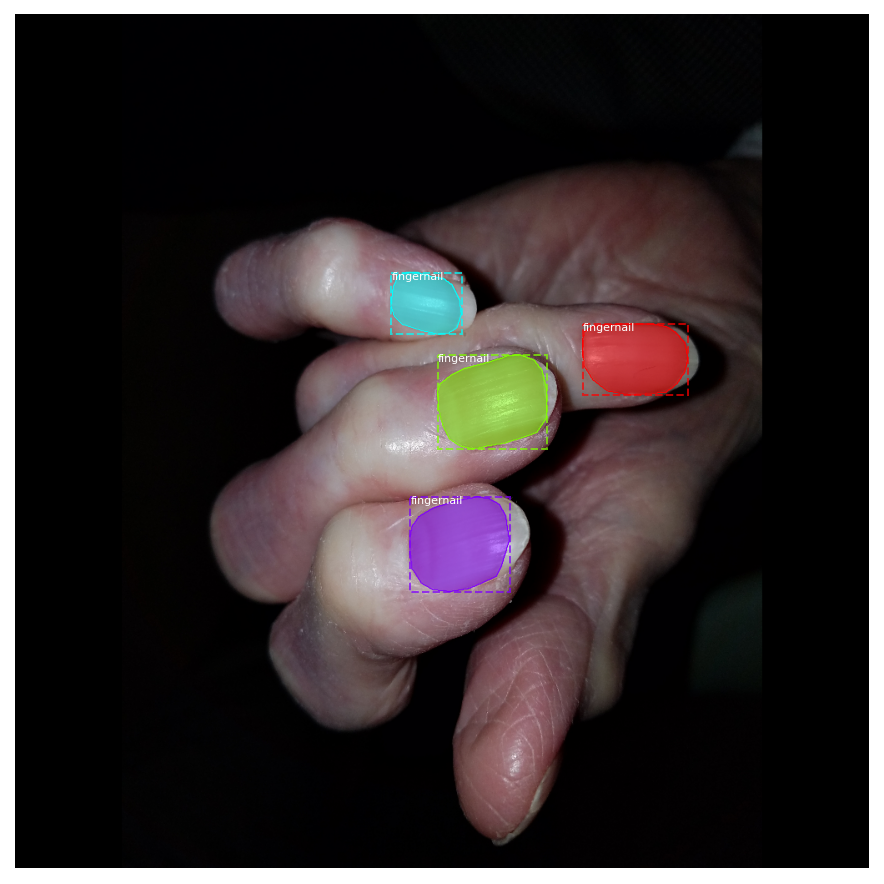

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [8]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  bool


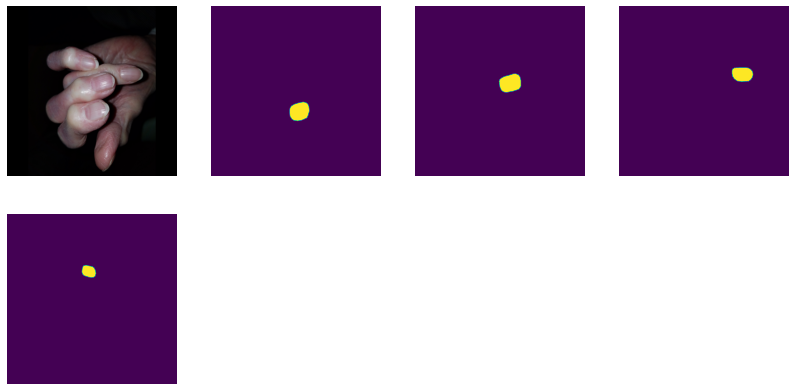

In [9]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id, augmentation=None)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

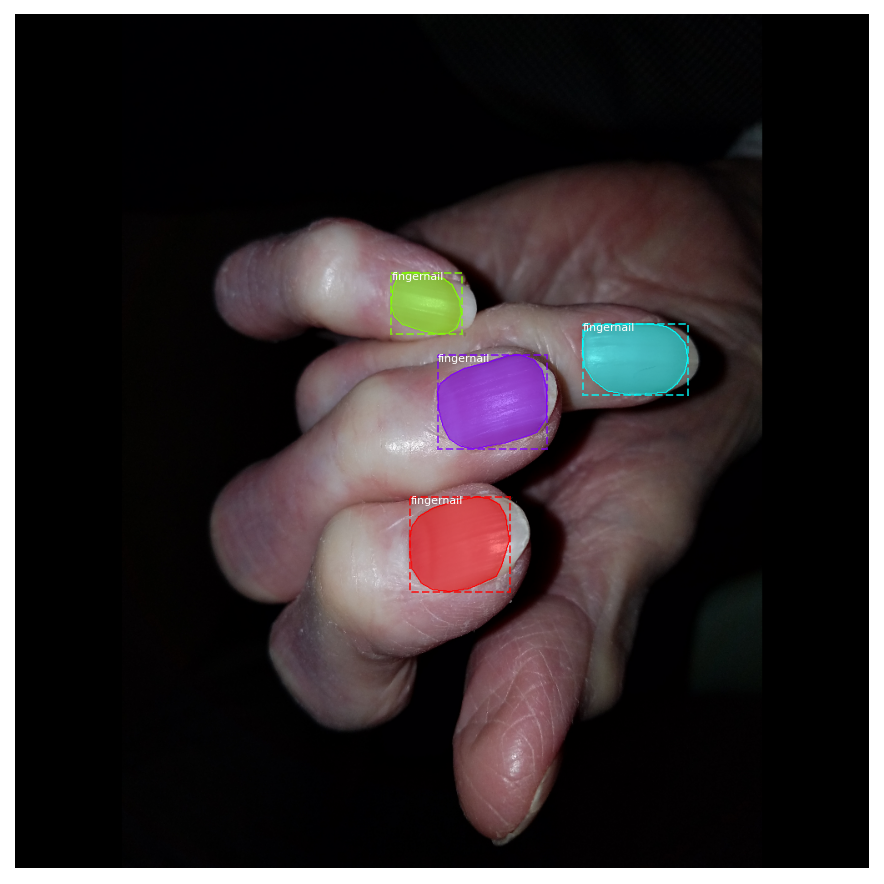

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [10]:
# Some how this line actually minimizes the mask
# TO DO: Fix utils.expand_mask()
#mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [11]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


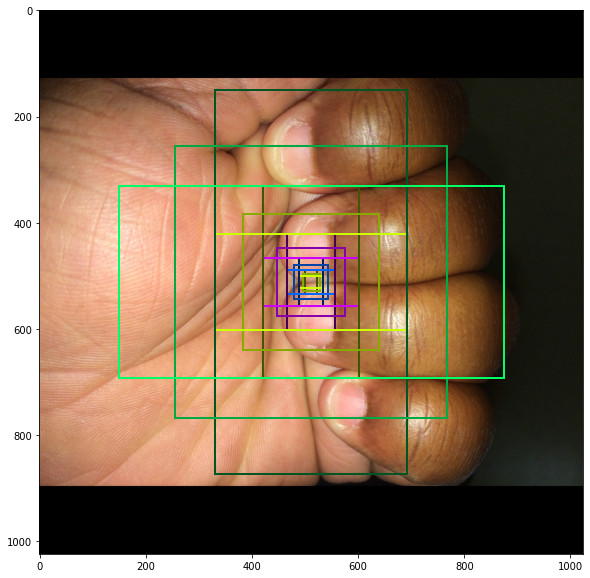

In [12]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


In [13]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [14]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 200, 4)           min:    1.00000  max: 1010.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 200, 2, 4)        min:   -3.05785  max:    3.35821  float32
mrcnn_mask               shape: (4, 200, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  888.00000  int32
gt_masks                 shape: (4, 1024, 1024, 100)  min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -2.42188  max:    2.57812  float64
image_id:  38 /Users/parker/Desktop/Mask_RCNN/datasets/fingernail/train/aapl12.png


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (16, 4)               min:  225.00000  max:  888.00000  float32
Positive anchors: 16
Negative anchors: 240
Neutral anchors: 261632
BG                     : 182
fingernail             : 18


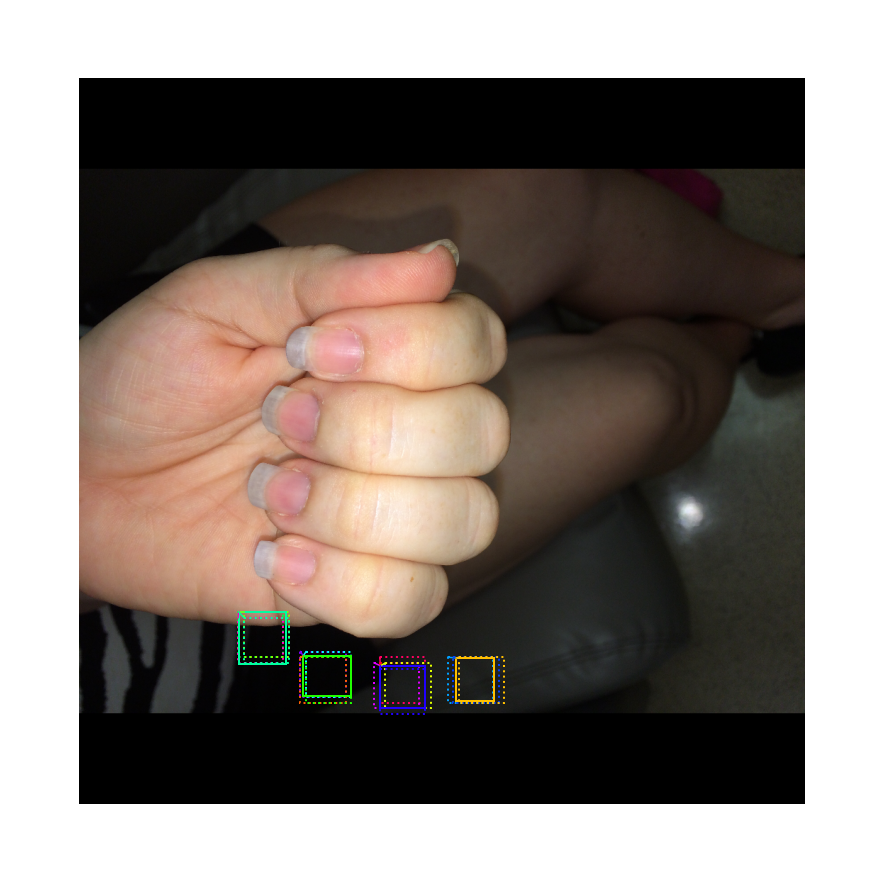

In [15]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

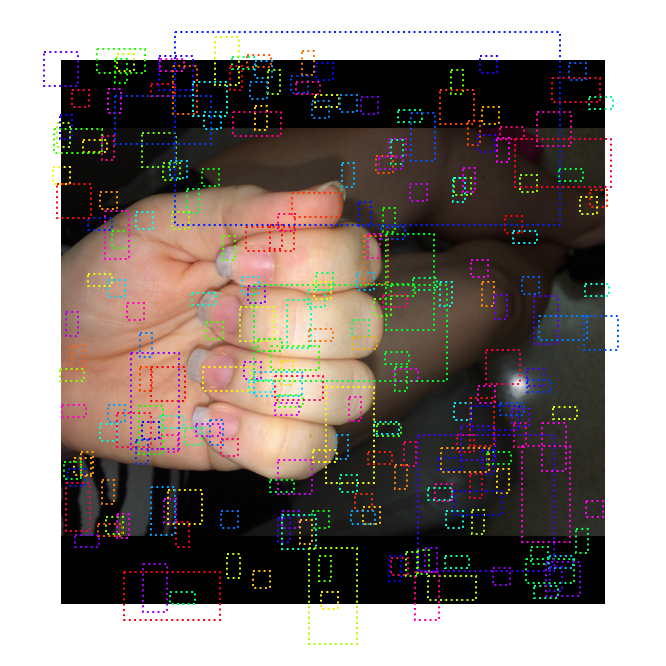

In [16]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

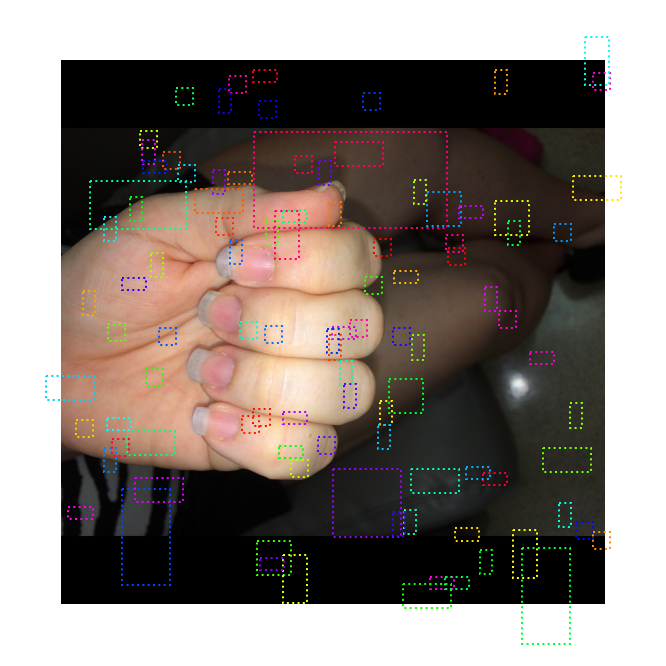

In [17]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

Positive ROIs:  18
Negative ROIs:  182
Positive Ratio: 0.09
Unique ROIs: 200 out of 200


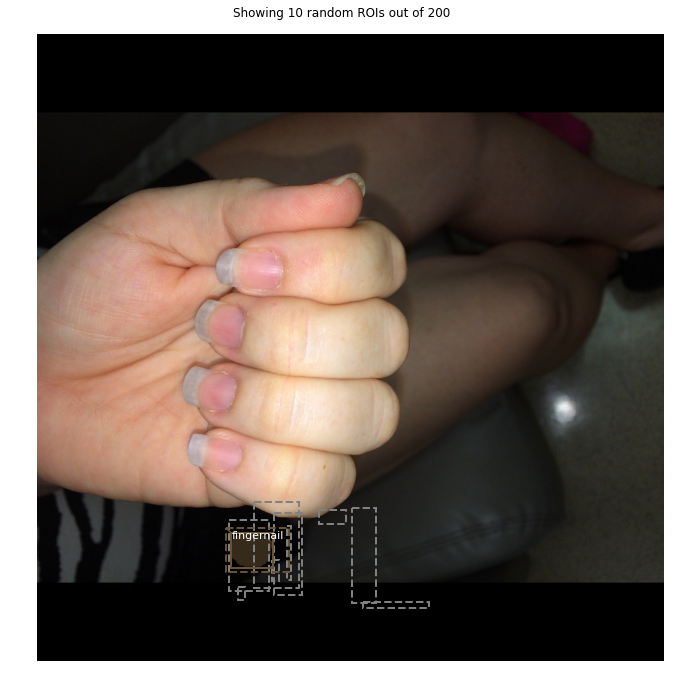

In [18]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

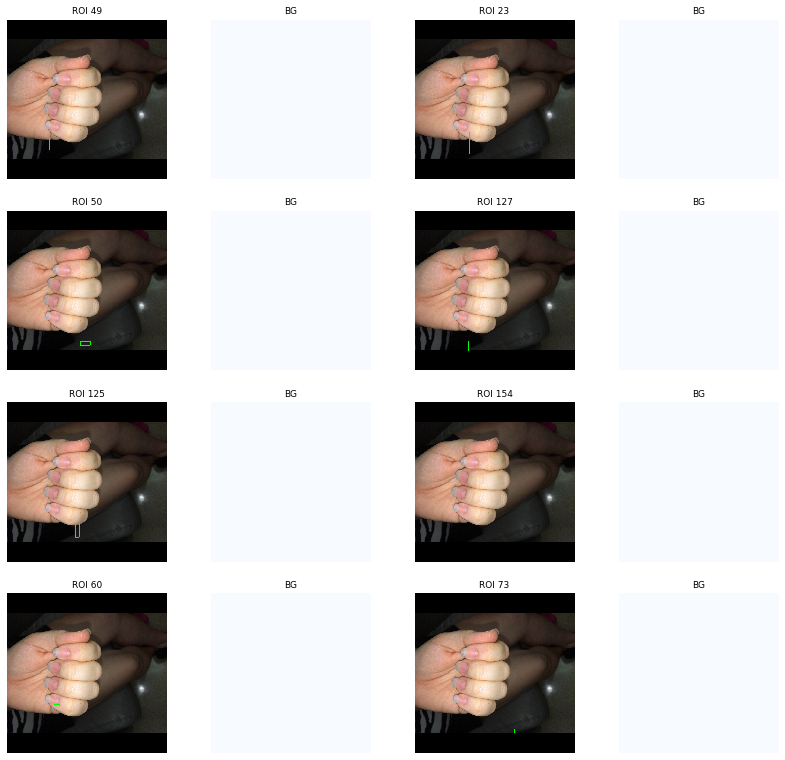

In [19]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [20]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33


ERROR:root:Error processing image {'id': 'aapl15.png', 'source': 'fingernail', 'path': '/Users/parker/Desktop/Mask_RCNN/datasets/fingernail/train/aapl15.png', 'width': 3264, 'height': 2448, 'polygons': [{'name': 'polyline', 'all_points_x': [229, 179, 126, 88, 63, 58, 71, 106, 146, 239, 305, 373, 418, 441, 441, 411, 370, 343, 297, 269, 212], 'all_points_y': [1677, 1682, 1690, 1705, 1725, 1753, 1791, 1826, 1846, 1854, 1851, 1833, 1816, 1778, 1763, 1743, 1708, 1682, 1662, 1667, 1680]}, {'name': 'polyline', 'all_points_x': [801, 829, 856, 866, 856, 826, 783, 758, 745, 728, 715, 688, 665, 652, 647, 650, 662, 685, 710, 740, 796, 813], 'all_points_y': [1635, 1619, 1592, 1564, 1539, 1511, 1468, 1428, 1395, 1383, 1390, 1415, 1443, 1483, 1519, 1567, 1592, 1622, 1642, 1652, 1647, 1627]}, {'name': 'polyline', 'all_points_x': [1007, 977, 962, 947, 944, 949, 965, 987, 1017, 1065, 1113, 1153, 1169, 1141, 1098, 1075, 1063, 1045, 1000], 'all_points_y': [1728, 1740, 1765, 1803, 1836, 1874, 1909, 1937, 1

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


In [21]:
# Perform model inference

config = fingernail.FingernailConfig()
FINGERNAIL_DIR = os.path.join(ROOT_DIR, "datasets/fingernail")

In [22]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [23]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [24]:
dataset = fingernail.FingernailDataset()
dataset.load_fingernail(FINGERNAIL_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 22
Classes: ['BG', 'fingernail']


In [30]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Get last model checkpoint and load weights
#weights_path = model.find_last()
weights_path = "/Users/parker/Desktop/Mask_RCNN/logs/fingernails20211209T1702/mask_rcnn_fingernails_0030.h5"
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /Users/parker/Desktop/Mask_RCNN/logs/fingernails20211209T1702/mask_rcnn_fingernails_0030.h5
Re-starting from epoch 30


In [31]:
# keras_model is the actual model object
# Save it to pb, hdf5 and h5 format accordingly

model.keras_model.save("/Users/parker/Desktop/testing.pb")
#model.keras_model.save("/Users/parker/Desktop/testing.hdf5")
#model.keras_model.save("/Users/parker/Desktop/testing.h5")

INFO:tensorflow:Assets written to: /Users/parker/Desktop/testing.pb/assets


INFO:tensorflow:Assets written to: /Users/parker/Desktop/testing.pb/assets


In [28]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model.keras_model)
tflite_model = converter.convert()

# Save the model.
with open('/Users/parker/Desktop/model.tflite', 'wb') as f:
  f.write(tflite_model)

2022-01-03 11:35:39.397954: I tensorflow/core/grappler/devices.cc:60] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA support)
2022-01-03 11:35:39.398037: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-01-03 11:35:39.494868: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:797] Optimization results for grappler item: graph_to_optimize
2022-01-03 11:35:39.494882: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:799]   function_optimizer: Graph size after: 3030 nodes (0), 3265 edges (0), time = 25.984ms.
2022-01-03 11:35:39.494886: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:799]   function_optimizer: Graph size after: 3030 nodes (0), 3265 edges (0), time = 26.542ms.
2022-01-03 11:35:39.494888: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:797] Optimization results for grappler item: mask_rcnn_mrcnn_detection_map_while_cond_16172
2022-01-03 11:35:

NotImplementedError: numpy() is only available when eager execution is enabled.

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
img_data = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Save image to desktop as sample
plt.imsave("/Users/parker/Desktop/random_img_test.png", img_data)

image ID: fingernail.aasc39.png (21) /Users/parker/Desktop/Mask_RCNN/datasets/fingernail/val/aasc39.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


ValueError: Error when checking input: expected input_anchors to have shape (1, 4) but got array with shape (261888, 4)

Running on /Users/parker/Desktop/india-images/36l.png
Processing 1 images
image                    shape: (3264, 2448, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 3264.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


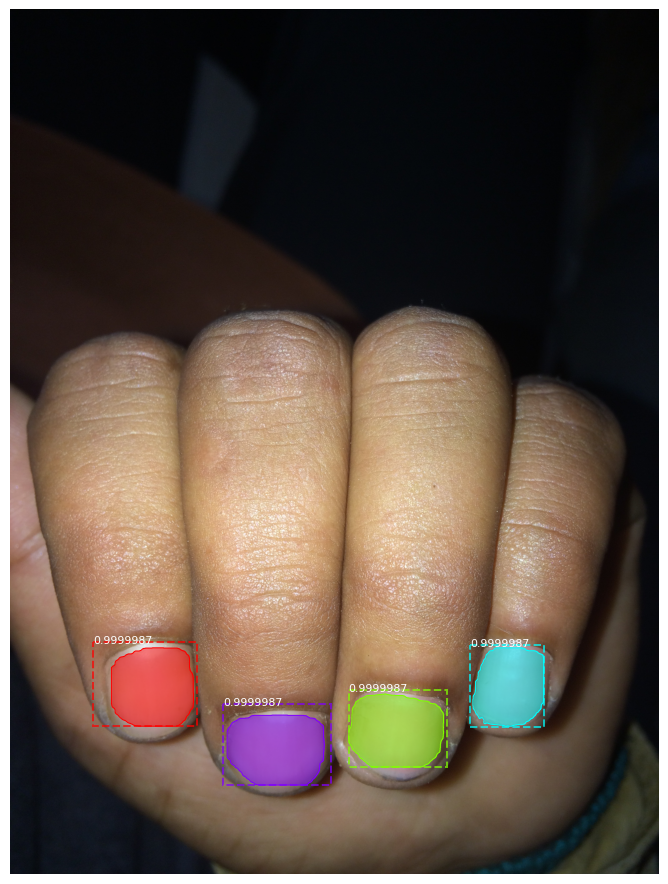

Saved to  /Users/parker/Desktop/splash_20220103T092121.png


In [ ]:
# Add video support

# Process:
# 1) Open fingernail image direction FINGERNAIL_DIR
# 2) Randomly select and image from validation set
# 3) Build image path using fingernail directory and randomly selected image
# 4) Perform detection and draw masks on images

import skimage
import numpy

image_path = '/Users/parker/Desktop/india-images/36l.png'
#image_path = '/Users/parker/Desktop/Mask_RCNN/datasets/fingernail/train/aarc44.png'

#fingernail.detect_and_draw(model, image_path=image_path)

video_path = '/Users/parker/Desktop/IMG_7597.mov'

fingernail.detect_and_draw(model, image_path=image_path)

In [ ]:
# TO DO: Figure out how to apply mask without using visualize.display_isntances

import cv2
import datetime

video_path = '/Users/parker/Desktop/IMG_7597.mov'

# Video capture
vcapture = cv2.VideoCapture(video_path)
width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = vcapture.get(cv2.CAP_PROP_FPS)

# Define codec and create video writer
file_name = "/Users/parker/Desktop/IMG_7597.avi".format(datetime.datetime.now())
vwriter = cv2.VideoWriter(file_name, cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))

count = 0
success = True
while success:
    print("frame: ", count)
    # Read next image
    success, image = vcapture.read()
    if success:
        # OpenCV returns images as BGR, convert to RGB
        image = image[..., ::-1]
        # Detect objects
        r = model.detect([image], verbose=0)[0]
        # Draw
        #img_data = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=get_ax(1), show=False)
        img_data = visualize.apply_mask(image, r['masks'])
        # RGB -> BGR to save image to video
        img_data = img_data[..., ::-1]
        # Add image to video writer
        vwriter.write(img_data)
        count += 1

vcapture.release()
vwriter.release()

frame:  0


TypeError: apply_mask() missing 1 required positional argument: 'color'

AttributeError: 'MaskRCNN' object has no attribute 'summary'